# Dimuon spectrum

This code is a columnar adaptation of [a ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) showcasing the awkward array toolset, and utilizing FCAT histograms.
This also shows the analysis object syntax implemented by FCAT `JaggedCandidateArray`, and the usage of an accumulator class provided by FCAT.  Further, it introduces the processor concept and the first level of scale-out, namely multicore local processing.

In [1]:
import time

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
import fnal_column_analysis_tools.processor as processor

In [2]:
# uproot supports xrootd, but its nicer to have them local (about 7 GB)
!mkdir -p data
!xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root data/
!xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root data/

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists



In [3]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class DimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        mass_axis = hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 30000, 0.25, 300)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content,
            )
        
        output['cutflow']['all events'] += muons.size
        
        twomuons = (muons.counts == 2)
        output['cutflow']['two muons'] += twomuons.sum()
        
        opposite_charge = twomuons & (muons['charge'].prod() == -1)
        output['cutflow']['opposite charge'] += opposite_charge.sum()
        
        dimuons = muons[opposite_charge].distincts()
        output['mass'].fill(dataset=dataset, mass=dimuons.mass.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
tstart = time.time()    

fileset = {
    'DoubleMuon': [
        'data/Run2012B_DoubleMuParked.root',
        'data/Run2012C_DoubleMuParked.root',
    ]
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=DimuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4},
                                  chunksize=500000,
                                 )

elapsed = time.time() - tstart
print(output)

100%|██████████| 133/133 [00:36<00:00,  3.60items/s]

{'mass': <Hist (dataset,mass) instance at 0x1216494a8>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 66128870, 'two muons': 33370298, 'opposite charge': 25794885})}


(0.1, 1000000.0)

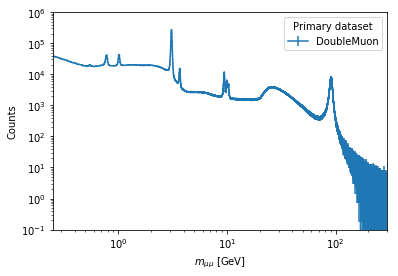

In [5]:
fig, ax, _ = plot.plot1d(output['mass'], overlay='dataset')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 1e6)

In [6]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 1776196.9183523513
